In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.losses import MeanSquaredError

In [2]:
df = pd.read_csv(r"F:\College\SEM 8\Project Phase 2\Dataset\NCA Preprocessed\master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [ ]:
# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)  
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


In [4]:
from tqdm import tqdm 

batch_size = 32

y_train_tf = y_train.reshape(-1,1).astype(np.float32)
y_test_tf = y_test.reshape(-1,1).astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_train.astype(np.float32),X_context_train.astype(np.float32),
     y_train_tf)).shuffle(buffer_size=len(X_ic_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_test.astype(np.float32), X_context_test.astype(np.float32),
    y_test_tf)).batch(batch_size)

In [5]:
def fgsm_attack(model, x_ic_batch, x_ctx_batch, y_batch, epsilon=0.02, clip_min=-3.0, clip_max=3.0):
    
    x_ic_adv = tf.Variable(x_ic_batch)  
    x_ctx_batch = tf.convert_to_tensor(x_ctx_batch)
    y_batch = tf.convert_to_tensor(y_batch)

    with tf.GradientTape() as tape:
        tape.watch(x_ic_adv)
        pred = model([x_ic_adv, x_ctx_batch], training=False)
        loss = tf.keras.losses.MeanSquaredError()(y_batch, pred)

    gradient = tape.gradient(loss, x_ic_adv)
    signed_grad = tf.sign(gradient)

    x_ic_adv = x_ic_adv + epsilon * signed_grad

    x_ic_adv = tf.clip_by_value(x_ic_adv, clip_min, clip_max)

    return x_ic_adv


In [6]:
cnn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn.keras")

In [7]:
print("Any NaN in y_batch? ", np.isnan(y_train).any())
print("Any Inf in y_batch? ", np.isinf(y_train).any())


Any NaN in y_batch?  False
Any Inf in y_batch?  False


In [8]:
print("NaN in IC:", np.isnan(X_ic_train).any())
print("NaN in Context:", np.isnan(X_context_train).any())


NaN in IC: False
NaN in Context: False


In [ ]:
epsilon = 0.01
learning_rate = 1e-5

best_val_mse = float('inf')
patience = 5
patience_counter = 0
epochs = 20

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_loss_fn = MeanSquaredError()

train_mae_history = []
train_mse_history = []
val_mse_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    total_mse = 0.0
    total_mae = 0.0
    num_batches = 0 

    train_pbar = tqdm(train_dataset, desc = "Training", leave=True)

    for(x_ic_batch , x_ctx_batch, y_batch) in train_pbar:

        x_adv = fgsm_attack(cnn, x_ic_batch, x_ctx_batch, y_batch, epsilon=epsilon)
        x_adv = tf.clip_by_value(x_adv, -3, 3)

        with tf.GradientTape() as tape:
            y_pred_adv = cnn([x_adv, x_ctx_batch], training = True)
            mse_loss = mse_loss_fn(y_batch,y_pred_adv)

        grads = tape.gradient(mse_loss, cnn.trainable_variables)
        optimizer.apply_gradients(zip(grads, cnn.trainable_variables))

        mae_metric.reset_state()
        mae_metric.update_state(y_batch, y_pred_adv)
        batch_mae = mae_metric.result().numpy()

        total_mse += mse_loss.numpy()
        total_mae += batch_mae
        num_batches+=1

        train_pbar.set_postfix(mse = f"{mse_loss.numpy():.6f}", mae=f"{batch_mae:.6f}")


    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    train_mse_history.append(avg_mse)
    train_mae_history.append(avg_mae)


    print(f"Train MSE: {avg_mse:.4f} | Train MAE : {avg_mae:.6f}")

    val_mse = 0.0
    num_val_batches = 0

    val_pbar = tqdm(test_dataset, desc = "Validating", leave=True)

    for(x_ic_batch,x_ctx_batch, y_batch) in val_pbar:
        pred_val = cnn([x_ic_batch, x_ctx_batch], training=False)
        batch_mse= mse_loss_fn(y_batch, pred_val).numpy()

        val_mse += batch_mse
        num_val_batches += 1

        val_pbar.set_postfix(mse=f"{batch_mse:.4f}")

    
    val_mse /=num_val_batches
    val_mse_history.append(val_mse)

    print(f"Validation MSE: {val_mse:.4f}")

    if val_mse < best_val_mse:
        print("Validation improved, saving model ...")
        best_val_mse = val_mse
        patience_counter = 0
        cnn.save("fgsm_trained_cnn.keras")

    else:
        patience_counter +=1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break   


Epoch 1/20


Training:   0%|          | 0/566 [00:00<?, ?it/s]

Training: 100%|██████████| 566/566 [03:32<00:00,  2.66it/s, mae=0.172228, mse=0.045746]


Train MSE: 0.0822 | Train MAE : 0.212681


Validating: 100%|██████████| 142/142 [00:04<00:00, 32.15it/s, mse=0.0483]


Validation MSE: 0.0399
Validation improved, saving model ...

Epoch 2/20


Training: 100%|██████████| 566/566 [02:22<00:00,  3.97it/s, mae=0.223923, mse=0.104759]


Train MSE: 0.0665 | Train MAE : 0.190325


Validating: 100%|██████████| 142/142 [00:04<00:00, 31.77it/s, mse=0.0505]


Validation MSE: 0.0414
No improvement. Patience: 1/5

Epoch 3/20


Training: 100%|██████████| 566/566 [01:47<00:00,  5.25it/s, mae=0.218836, mse=0.073101]


Train MSE: 0.0649 | Train MAE : 0.186863


Validating: 100%|██████████| 142/142 [00:04<00:00, 31.76it/s, mse=0.0542]


Validation MSE: 0.0396
Validation improved, saving model ...

Epoch 4/20


Training: 100%|██████████| 566/566 [01:34<00:00,  6.02it/s, mae=0.152554, mse=0.038082]


Train MSE: 0.0624 | Train MAE : 0.183266


Validating: 100%|██████████| 142/142 [00:02<00:00, 50.37it/s, mse=0.0480]


Validation MSE: 0.0351
Validation improved, saving model ...

Epoch 5/20


Training: 100%|██████████| 566/566 [01:19<00:00,  7.08it/s, mae=0.204422, mse=0.068847]


Train MSE: 0.0598 | Train MAE : 0.178199


Validating: 100%|██████████| 142/142 [00:02<00:00, 48.54it/s, mse=0.0599]


Validation MSE: 0.0426
No improvement. Patience: 1/5

Epoch 6/20


Training: 100%|██████████| 566/566 [01:21<00:00,  6.94it/s, mae=0.174871, mse=0.047360]


Train MSE: 0.0597 | Train MAE : 0.178851


Validating: 100%|██████████| 142/142 [00:02<00:00, 48.63it/s, mse=0.0554]


Validation MSE: 0.0409
No improvement. Patience: 2/5

Epoch 7/20


Training: 100%|██████████| 566/566 [01:22<00:00,  6.83it/s, mae=0.163506, mse=0.038215]


Train MSE: 0.0586 | Train MAE : 0.176299


Validating: 100%|██████████| 142/142 [00:02<00:00, 50.10it/s, mse=0.0491]


Validation MSE: 0.0341
Validation improved, saving model ...

Epoch 8/20


Training: 100%|██████████| 566/566 [01:37<00:00,  5.78it/s, mae=0.182639, mse=0.078576]


Train MSE: 0.0576 | Train MAE : 0.174019


Validating: 100%|██████████| 142/142 [00:04<00:00, 34.14it/s, mse=0.0495]


Validation MSE: 0.0366
No improvement. Patience: 1/5

Epoch 9/20


Training: 100%|██████████| 566/566 [01:23<00:00,  6.77it/s, mae=0.156108, mse=0.046134]


Train MSE: 0.0561 | Train MAE : 0.172426


Validating: 100%|██████████| 142/142 [00:02<00:00, 52.70it/s, mse=0.0398]


Validation MSE: 0.0291
Validation improved, saving model ...

Epoch 10/20


Training: 100%|██████████| 566/566 [01:23<00:00,  6.82it/s, mae=0.158596, mse=0.043356]


Train MSE: 0.0562 | Train MAE : 0.172399


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.55it/s, mse=0.0451]


Validation MSE: 0.0320
No improvement. Patience: 1/5

Epoch 11/20


Training: 100%|██████████| 566/566 [01:17<00:00,  7.33it/s, mae=0.144312, mse=0.043917]


Train MSE: 0.0553 | Train MAE : 0.171107


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.75it/s, mse=0.0552]


Validation MSE: 0.0365
No improvement. Patience: 2/5

Epoch 12/20


Training: 100%|██████████| 566/566 [01:18<00:00,  7.19it/s, mae=0.170801, mse=0.053428]


Train MSE: 0.0551 | Train MAE : 0.170268


Validating: 100%|██████████| 142/142 [00:02<00:00, 49.63it/s, mse=0.0451]


Validation MSE: 0.0327
No improvement. Patience: 3/5

Epoch 13/20


Training: 100%|██████████| 566/566 [01:51<00:00,  5.08it/s, mae=0.218138, mse=0.080359]


Train MSE: 0.0530 | Train MAE : 0.165963


Validating: 100%|██████████| 142/142 [00:03<00:00, 36.06it/s, mse=0.0429]


Validation MSE: 0.0278
Validation improved, saving model ...

Epoch 14/20


Training: 100%|██████████| 566/566 [02:03<00:00,  4.59it/s, mae=0.127330, mse=0.024476]


Train MSE: 0.0535 | Train MAE : 0.166998


Validating: 100%|██████████| 142/142 [00:03<00:00, 38.65it/s, mse=0.0449]


Validation MSE: 0.0341
No improvement. Patience: 1/5

Epoch 15/20


Training: 100%|██████████| 566/566 [02:06<00:00,  4.48it/s, mae=0.200684, mse=0.068815]


Train MSE: 0.0521 | Train MAE : 0.165039


Validating: 100%|██████████| 142/142 [00:03<00:00, 40.59it/s, mse=0.0493]


Validation MSE: 0.0342
No improvement. Patience: 2/5

Epoch 16/20


Training: 100%|██████████| 566/566 [02:15<00:00,  4.19it/s, mae=0.125605, mse=0.030501]


Train MSE: 0.0513 | Train MAE : 0.165433


Validating: 100%|██████████| 142/142 [00:03<00:00, 36.29it/s, mse=0.0427]


Validation MSE: 0.0312
No improvement. Patience: 3/5

Epoch 17/20


Training: 100%|██████████| 566/566 [02:13<00:00,  4.24it/s, mae=0.139082, mse=0.047204]


Train MSE: 0.0521 | Train MAE : 0.165081


Validating: 100%|██████████| 142/142 [00:04<00:00, 33.19it/s, mse=0.0501]


Validation MSE: 0.0335
No improvement. Patience: 4/5

Epoch 18/20


Training: 100%|██████████| 566/566 [02:16<00:00,  4.16it/s, mae=0.167105, mse=0.048288]


Train MSE: 0.0514 | Train MAE : 0.163705


Validating: 100%|██████████| 142/142 [00:03<00:00, 37.89it/s, mse=0.0421]


Validation MSE: 0.0304
No improvement. Patience: 5/5
Early stopping triggered


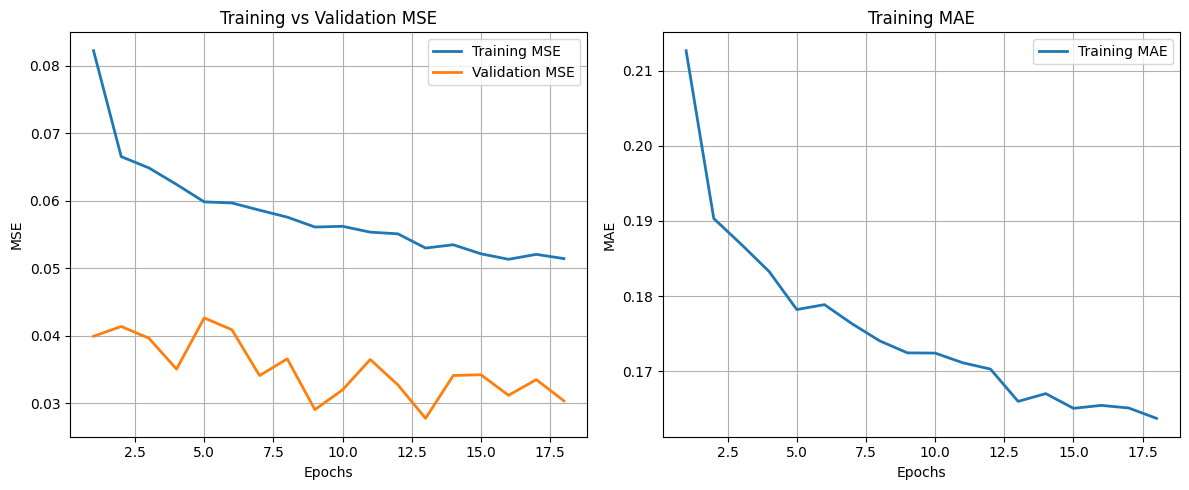

Saved training curves to adv_training_curves_fgsm_cnn.png


In [10]:
import matplotlib.pyplot as plt

# Number of epochs actually completed
epochs_ran = len(train_mse_history)

plt.figure(figsize=(12, 5))

# ---------------- MSE Plot ----------------
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ran + 1), train_mse_history, label='Training MSE', linewidth=2)
plt.plot(range(1, epochs_ran + 1), val_mse_history, label='Validation MSE', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training vs Validation MSE")
plt.legend()
plt.grid(True)

# ---------------- MAE Plot ----------------
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ran + 1), train_mae_history, label='Training MAE', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("adv_training_curves_fgsm_cnn.png", dpi=300)
plt.show()

print("Saved training curves to adv_training_curves_fgsm_cnn.png")


In [11]:
adv_fgsm_cnn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\fgsm_trained_cnn.keras")

In [22]:


# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)  
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


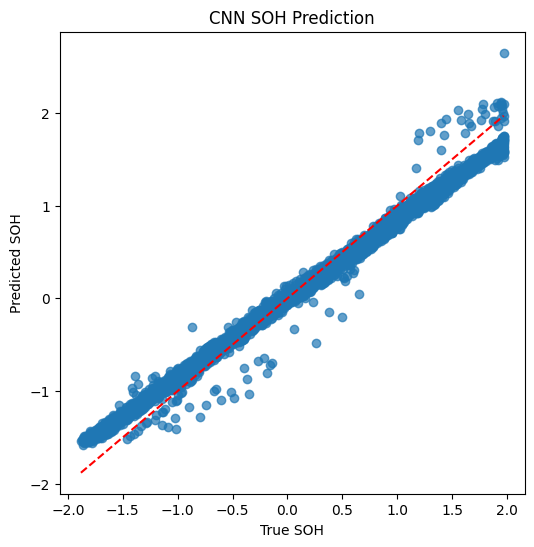

In [23]:
import matplotlib.pyplot as plt

y_pred = adv_fgsm_cnn.predict([X_ic_test, X_context_test]).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True SOH")
plt.ylabel("Predicted SOH")
plt.title("CNN SOH Prediction")
plt.show()

In [28]:
print(len(X_ic_all))

22637


In [18]:
def fgsm_attack(model, X_ic_test, X_context_test, y_test, epsilon = 0.05):
    X_ic_adv = tf.convert_to_tensor(X_ic_test)
    X_context_test = tf.convert_to_tensor(X_context_test)
    y_true = tf.convert_to_tensor(y_test)
    
    with tf.GradientTape() as tape:
        tape.watch(X_ic_adv)
        y_pred = model([X_ic_adv, X_context_test],training=False)
        loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    gradient = tape.gradient(loss, X_ic_adv)
    signed_grad = tf.sign(gradient)
    X_ic_adv = X_ic_adv + epsilon * signed_grad

    return X_ic_adv.numpy()


In [17]:
from sklearn.metrics import mean_absolute_percentage_error

def attack_eval(model, X_ic_test, X_context_test, y_test, epsilon, model_name=""):
    # Ensure numpy arrays with correct dtype and 1D targets
    X_ic_test = np.array(X_ic_test, dtype=np.float32)
    X_context_test = np.array(X_context_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32).ravel()

    # Generate adversarial IC inputs (returns numpy or tensor-like)
    X_ic_test_adv = fgsm_attack(model, X_ic_test, X_context_test, y_test, epsilon)

    # Get predictions and ensure they are 1D numpy arrays
    y_pred = np.array(model.predict([X_ic_test, X_context_test])).ravel()
    y_pred_adv = np.array(model.predict([X_ic_test_adv, X_context_test])).ravel()

    # Compute metrics on flattened arrays
    print("-----------------")
    print("Normal Condition")
    print("-----------------")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

    print("-------------")
    print("Attacked Data")
    print("-------------")
    print("R2 Score:", r2_score(y_test, y_pred_adv))
    print("MAE:", mean_absolute_error(y_test, y_pred_adv))
    print("MSE:", mean_squared_error(y_test, y_pred_adv))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_adv))

    print("-----")
    print("Plots")
    print("-----")

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred, alpha = 0.5)
    plt.title(model_name+" Clean Data Predictions")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_adv, alpha=0.5, color="orange")
    plt.title(model_name+" Attacked Data Predicitions")
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()
    plt.show()


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
----------------------------------
Normal Condition
-----------------
R2 Score: 0.972354531288147
MAE: 0.13769401609897614
MSE: 0.02772129327058792
MAPE: 0.9288401007652283
-------------
Attacked Data
-------------
R2 Score: 0.8958057165145874
MAE: 0.2818340063095093
MSE: 0.10448015481233597
MAPE: 7.962990760803223
-----
Plots
-----

Normal Condition
-----------------
R2 Score: 0.972354531288147
MAE: 0.13769401609897614
MSE: 0.02772129327058792
MAPE: 0.9288401007652283
-------------
Attacked Data
-------------
R2 Score: 0.8958057165145874
MAE: 0.2818340063095093
MSE: 0.10448015481233597
MAPE: 7.962990760803223
-----
Plots
-----


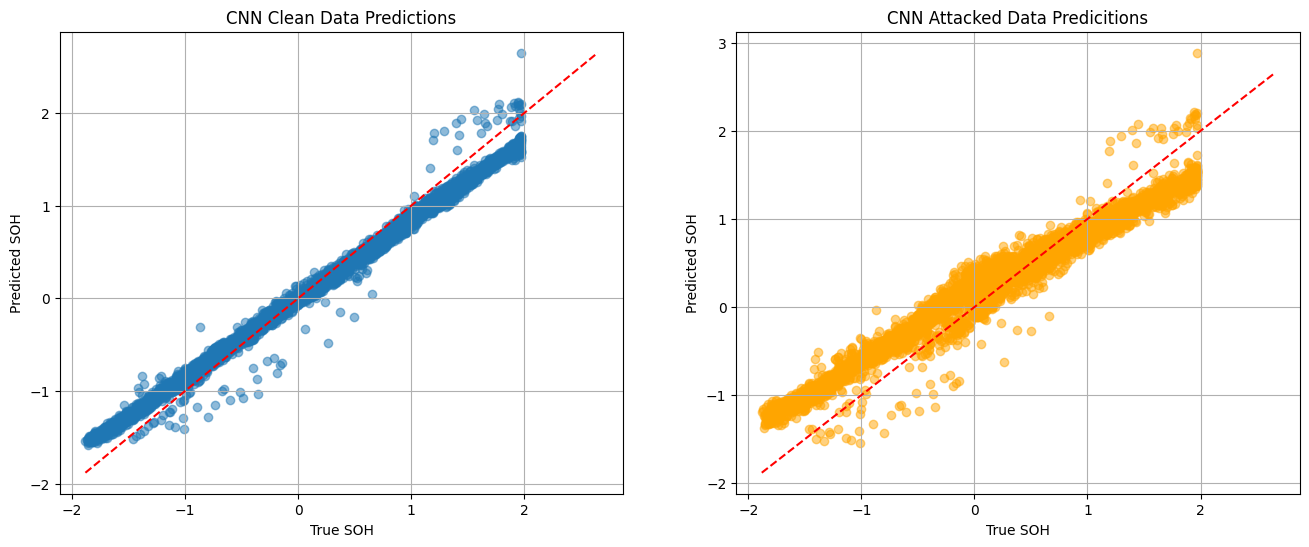

In [39]:
attack_eval(adv_fgsm_cnn, X_ic_test, X_context_test, y_test, epsilon = 0.2, model_name="CNN")